In [1]:
import sys
from pathlib import Path
main_dir = str(Path.cwd().parent)
if main_dir not in sys.path:
    sys.path.append(main_dir)

import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from environment.market import MarketEnv
from environment.puppet import *
from tqdm import tqdm
import logging
from visualization.env_status import policy_plot
from models.MLP import SimpleBrokerDRL

from IPython.display import clear_output
from itertools import product

<Axes: xlabel='Группа товаров', ylabel='Объём покупок'>

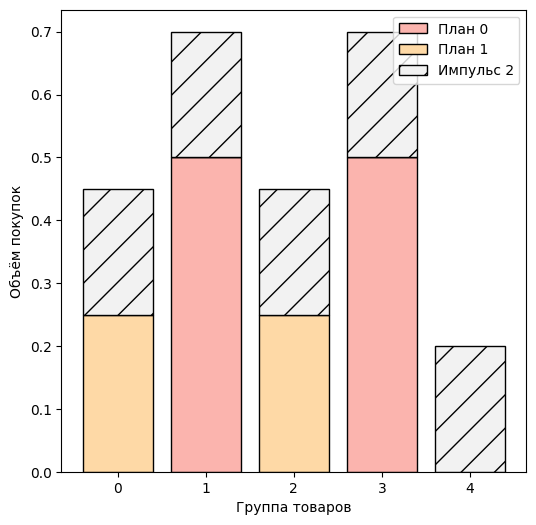

In [32]:
K_GROUPS = 5
K_CONS_GROUPS = 2
K_ADD_GROUPS = K_GROUPS
K_ACTIONS = 6

func = ImpulseFunc(base=0., coef=1.7, level=np.array([0.3, 0.3, 0.4, 0.6, 0.5]))
cons_list = [ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=1.),
             ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=0.5),
             ImpulseConsumer(K_GROUPS, K_ADD_GROUPS, func)]
cons_list[0].list_policy = np.array([0,0.5,0,0.5,0])
cons_list[1].list_policy = np.array([0.25,0,0.25,0,0])
env = MarketEnv(K_GROUPS, k_actions=3, fix_stock=100, consumer_list=cons_list, max_ep=50, action_type='step')
policy_plot(env)

# NSGA-II

In [9]:
def f(x):
    prices = 1 - x
    res = []
    for c in env.c_list:
        rew, sold = c.substep(prices)
        res.append(rew)
    return np.array(res)

class Solution():

    def __init__(self):
        self.rank = None
        self.cr_dist = None
        self.k_domination = None
        self.dominated_sols = None
        self.s = None
        self.f = None

    def __eq__(self, other):
        return (self.s == other.s).all()

    def dominates(self, other):
        return (self.f <= other.f).all() and (self.f < other.f).any()

In [10]:
f(np.array([0]*K_GROUPS))

array([1., 0.])

## Solution features calculation

Each solution has two essensial features for NSGA-II algorithm:

    1)  front position = rank
    2)  crowding distance through its front

### FNDS Algorithm (1):

    s0 dominates s1 =
        (f_i(s0) <= f_i(s1) in every function f_i)
        and
        (f_*(s0) < f_*(s1) in at least one function f_*),

    for each solution s01:
        list of solutions, which are dominated by s01
        number of solutions which dominates s01 (k_domination)
    zero-front = solutions which are not dominated by anyone (their rank = 0)

    for every front:
        for every sol0 in front:
            for every dominated solution sol1 of sol0:
                decrease k_domination of s01

    i+1-th front = solutions dominated by one of i front which k_domination became zero while going through i-th front (their rank equals number of their front)

### crowd_distance of front (2):
    init all dists of front's solutions as zero

    sort front solutions by every function (f_m):
      first and last solution's distance is infinite (10^6)
      for others:
          dist[i] += (f_m[i+1] - f_m[i+1]) / (max(f_m) - min(f_m) OR 1)
          ([i] - index of solution through m-th sort)


In [11]:
def fast_nondominated_sort(sol_list):
    fronts = [[]]
    for i, s0 in enumerate(sol_list):
        ds0 = []
        s0.k_domination = 0
        for j, s1 in enumerate(sol_list):
            if s0.dominates(s1):
                ds0.append(s1)
            elif s1.dominates(s0):
                s0.k_domination += 1
        if s0.k_domination == 0:
            s0.rank = 0
            fronts[0].append(s0)
        s0.dominated_sols = ds0
    i = 0
    while len(fronts[i]) > 0:
        fr0 = []
        for s0 in fronts[i]:
            for s1 in s0.dominated_sols:
                s1.k_domination -= 1
                if s1.k_domination == 0:
                    s1.rank = i + 1
                    fr0.append(s1)
        i = i + 1
        fronts.append(fr0)
    return fronts

def crowd_distance_of(front):
    if len(front) > 0:
        k_sol = len(front)
        for s in front:
            s.cr_dist = 0
        for m in range(len(front[0].f)):
            front.sort(key=lambda s0: s0.f[m])
            front[0].cr_dist = 10 ** 6
            front[-1].cr_dist = 10 ** 6
            m_values = [s0.f[m] for s0 in front]
            scale = max(m_values) - min(m_values)
            if scale == 0: scale = 1
            for i in range(1, k_sol - 1):
                front[i].cr_dist += (front[i + 1].f[m] - front[i - 1].f[m]) / scale

## Parent Selection

### s0 is "better" than s1:
(rank of s0 is lower than s1's) OR (crowding distance of s0 is higher than s1's (if their ranks are equal))

### Tournament (parent gen):
    linear tournament (for new in generation):
        best = new, if (new is better than best and random < tour_rate)

### Parents:
    distinct winners of tournaments

In [12]:
def crowding_operator(s0, s1):
        if (s0.rank < s1.rank) or \
                ((s0.rank == s1.rank) and (
                        s0.cr_dist > s1.cr_dist)):
            return 1
        else:
            return -1

def create_children(s, cross, mut, tour, k, bounds):
    children = []
    while len(children) < len(s):
        parent1 = tournament(s, k, tour)
        parent2 = parent1
        while parent1 == parent2:
            parent2 = tournament(s, k, tour)
        child1, child2 = crossover(parent1, parent2, cross)
        mutate(child1, mut, bounds); mutate(child2, mut, bounds)
        child1.f = f(child1.s); child2.f = f(child2.s)
        children.append(child1); children.append(child2)
    return children


def tournament(s, k_tour, choose_prob):
    participants = random.sample(s, k_tour)
    best = None
    for participant in participants:
        if best is None or (
                crowding_operator(participant, best) == 1 and random.random() <= choose_prob):
            best = participant
    return best

## New Gen

### SBX (simulation binary crossover):
    beta_vec = (beta(cross_rate) for i in parent.shape)
    child1 = ((1-beta_vec) parent1 + (1+beta_vec) parent2) / 2
    child2 = ((1+beta_vec) parent1 + (1-beta_vec) parent2) / 2

$\beta(r_c) =
\begin{cases}
2u^{\frac{1}{r_c + 1}},\ u = Uniform(0,1) \leq 0.5 \\
\frac{1}{2(1-u)}^{\frac{1}{r_c + 1}},\ else
\end{cases}$

### Polinomial mutation:

n = child.shape

delta_vec = [delta(mut_rate) for i in child.shape]

child += delta_vec * (upper_bounds - lower_bounds)

child = clip(child, lower_bounds, upper_bounds)


$\delta(r_m) = \begin{cases}
\begin{cases}
2r^{\frac{1}{r_m + 1}} + 1,\ r = Uniform(0,1) \leq 0.5 \\
1 - 2(1-r)^{\frac{1}{r_m + 1}},\ else
\end{cases}, P = Uniform(0,1) < 1/n \\
0, else
\end{cases}$



In [13]:
def crossover(s0, s1, rate):
    child1 = Solution(); child2 = Solution()
    beta = np.array([get_beta(rate) for i in range(s0.s.shape[0])])
    x1 = (s0.s + s1.s) / 2
    x2 = (s0.s - s1.s) / 2
    child1.s = x1 + beta * x2
    child2.s = x1 - beta * x2
    return child1, child2

def get_beta(cross_rate):
    u = random.random()
    if u <= 0.5:
        return (2 * u) ** (1 / (cross_rate + 1))
    return (2 * (1 - u)) ** (-1 / (cross_rate + 1))

def mutate(child, rate, bounds):
    delta = np.array([get_delta(rate) for i in range(child.s.shape[0])])
    P = np.array([random.random() for i in range(child.s.shape[0])])
    delta[P > 1/child.s.shape[0]] = 0

    child.s += delta * (bounds[:,1] - bounds[:,0])
    child.s = np.clip(child.s, bounds[:,0], bounds[:,1])

def get_delta(mut_rate):
    u = random.random()
    if u < 0.5:
        return (2 * u) ** (1 / (mut_rate + 1)) - 1
    return 1 - (2 * (1 - u)) ** (1 / (mut_rate + 1))

## Initial state

In [14]:
lower = np.full(K_GROUPS,0.)
upper = np.full(K_GROUPS,0.5)
x0 = np.linspace(lower[0],upper[0],4)
s_start = np.array(list(product(x0, repeat=K_GROUPS)))

CROSS_RATE = 2
MUT_RATE = 5
TOUR_RATE = 0.9
K_TOUR = 30
BOUNDS = np.array([lower, upper]).T

n_popul = len(s_start)
num_of_generations = 100

sol0 = [Solution() for i in range(n_popul)]
for i, s in enumerate(sol0):
    s.s = s_start[i].copy()
    s.f = f(s.s)

fronts = fast_nondominated_sort(sol0)
for front in fronts:
    crowd_distance_of(front)
children = create_children(sol0, CROSS_RATE, MUT_RATE, TOUR_RATE, K_TOUR, BOUNDS)

## Evolution process
old_generation = parents

compound_generation = parents + children

new_generation = $\sum_{i=0}^{\sum |fronts| < |generation|} fronts(compound\_generation)_i$

(объединенное поколение родителей и детей распределяется по фронтам, новое поколение - это объединение первых фронтов (решений с наименьшим рангом) до заполнения заданного объема поколения (последний фронт берется неполность по наибольшим растояниям внутри фронта до заполнения поколения))

In [15]:
pbar = tqdm(range(num_of_generations))
for i in pbar:
    sol0.extend(children)
    fronts = fast_nondominated_sort(sol0)
    new_sol = []
    front_num = 0
    while len(new_sol) + len(fronts[front_num]) <= n_popul:
        crowd_distance_of(fronts[front_num])
        new_sol.extend(fronts[front_num])
        front_num += 1
    crowd_distance_of(fronts[front_num])
    fronts[front_num].sort(key=lambda s0: s0.cr_dist, reverse=True)
    new_sol.extend(fronts[front_num][0:n_popul - len(new_sol)])
    last_sol = sol0
    sol0 = new_sol
    fronts = fast_nondominated_sort(sol0)
    for front in fronts:
        crowd_distance_of(front)
    fs = []
    for s in fronts[0]:
        fs.append(s.f.sum())
    pbar.set_description(f"Mean Reward {np.mean(fs):.2f}")
    children = create_children(sol0, CROSS_RATE, MUT_RATE, TOUR_RATE, K_TOUR, BOUNDS)


Mean Reward 0.70:   1%|          | 1/100 [00:14<23:22, 14.17s/it]


KeyboardInterrupt: 

# Simple Genetic

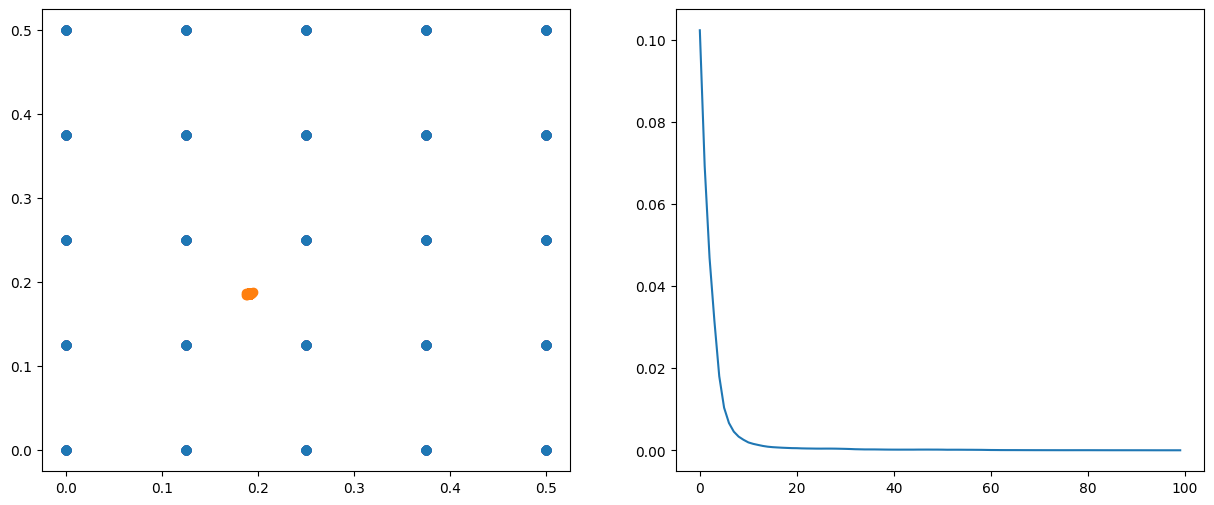

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

x_best =  [0.19170592 0.18674351 0.25558554 0.00889643 0.35174885]
f_max =  [1.8932004]


In [33]:
def f(x_vec):
    res = []
    for x in x_vec:
        prices = 1 - x
        rew0 = 0
        for c in env.c_list:
            rew, sold = c.substep(prices)
            rew0 += rew
        res.append(rew0)
    return np.array(res)
    
lower = np.full(K_GROUPS,0.)
upper = np.full(K_GROUPS,0.5)
x0 = np.linspace(lower[0],upper[0],5)
s_start = np.array(list(product(x0, repeat=K_GROUPS)))
s0 = s_start.copy()
disps = []
for i in tqdm(range(100)):
    f0 = f(s0)
    proba = np.exp(f0) / np.exp(f0).sum() #selection
    s1_idx = np.array([np.random.choice(len(s0), 2, p=proba, replace=False) for i in range(len(s0))])
    s1 = s0[s1_idx].mean(axis=1)
    mut_idx = np.array([random.random() for i in range(len(s0))])
    mask = mut_idx < 1/5
    s1[mask] += np.random.normal(scale=0.2, size=((mask).sum(),K_GROUPS)) #mutation
    s1 = np.clip(s1, lower, upper)
    s01 = np.append(s0,s1, axis=0)
    s0 = s01[np.argsort(f(s01))[len(s0):]]

    disps.append(s0.var(axis=0).sum())
    if (i+1) % 20 == 0:
        clear_output()
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        ax[0].scatter(s_start[:,0], s_start[:,1], alpha=0.3)
        ax[0].scatter(s0[:,0], s0[:,1])
        ax[1].plot(disps)
        plt.show()
        print('x_best = ', s0.mean(axis=0))
        print('f_max = ', f(np.expand_dims(s0.mean(axis=0), axis=0)))

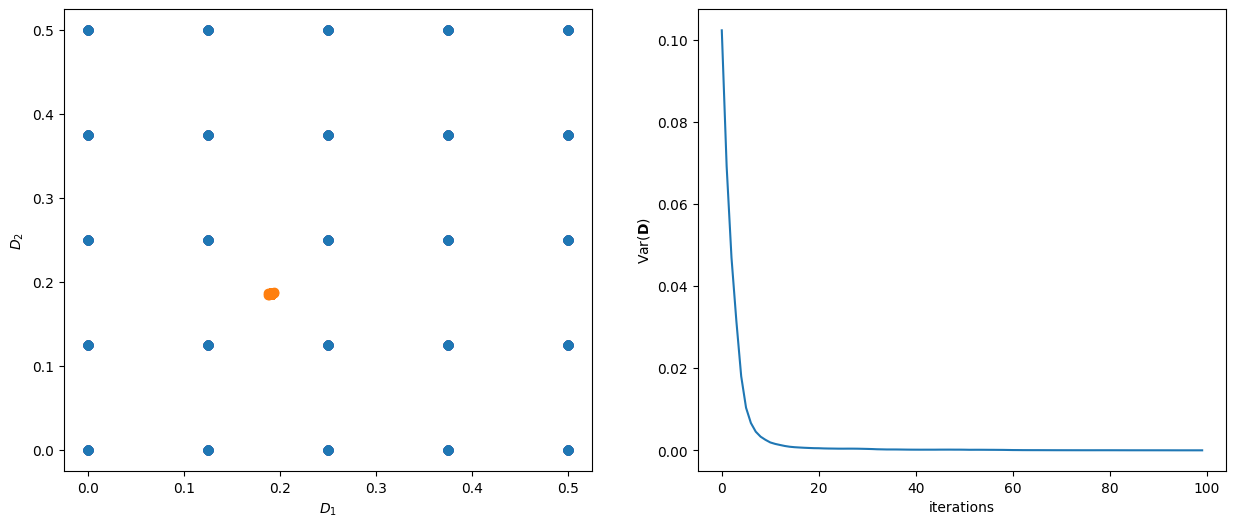

x_best =  [0.19170592 0.18674351 0.25558554 0.00889643 0.35174885]
f_max =  [1.8932004]


In [43]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].scatter(s_start[:,0], s_start[:,1], alpha=0.3)
ax[0].scatter(s0[:,0], s0[:,1])
ax[1].plot(disps)
ax[0].set_xlabel(r'$D_1$')
ax[0].set_ylabel(r'$D_2$')

ax[1].set_xlabel(r'iterations')
ax[1].set_ylabel(r'Var($\mathbf{D})$')
plt.show()
print('x_best = ', s0.mean(axis=0))
print('f_max = ', f(np.expand_dims(s0.mean(axis=0), axis=0)))

# Simple Genetic (random)

<Axes: xlabel='Группа товаров', ylabel='Объём покупок'>

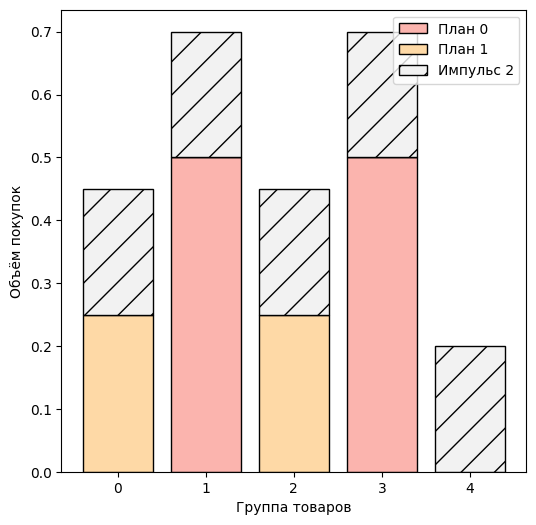

In [44]:
K_GROUPS = 5
K_CONS_GROUPS = 2
K_ADD_GROUPS = K_GROUPS
K_ACTIONS = 6

func = ImpulseFunc(base=0., coef=1.7)
cons_list = [ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=1.),
             ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=0.5),
             ImpulseConsumer(K_GROUPS, K_ADD_GROUPS, func)]
cons_list[0].list_policy = np.array([0,0.5,0,0.5,0])
cons_list[1].list_policy = np.array([0.25,0,0.25,0,0])
env = MarketEnv(K_GROUPS, k_actions=3, fix_stock=100, consumer_list=cons_list, max_ep=50, action_type='step')
policy_plot(env)

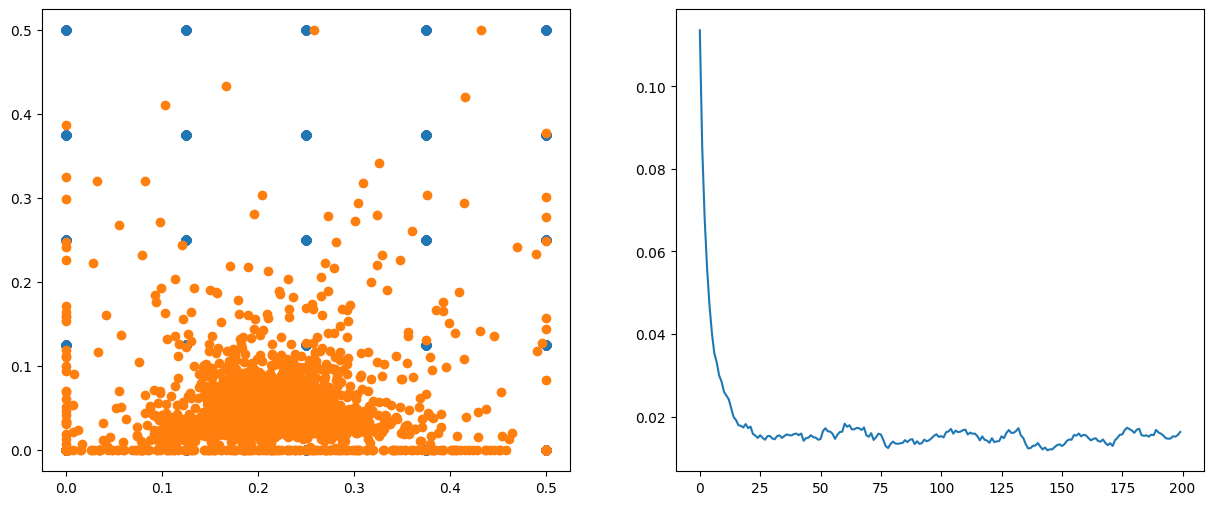

100%|██████████| 200/200 [04:35<00:00,  1.38s/it]

x_best =  [0.21417855 0.05087572 0.21072415 0.05149948 0.42375744]
f_max =  [1.7728547]


In [45]:
def f(x_vec):
    res = []
    for x in x_vec:
        prices = 1 - x
        rew0 = 0
        for c in env.c_list:
            rew, sold = c.substep(prices)
            rew0 += rew
        res.append(rew0)
    return np.array(res)

np.random.seed(1234)

lower = np.full(K_GROUPS,0.)
upper = np.full(K_GROUPS,0.5)
x0 = np.linspace(lower[0],upper[0],5)
s_start = np.array(list(product(x0, repeat=K_GROUPS)))
s0 = s_start.copy()
disps = []
for i in tqdm(range(200)):
    f0 = f(s0)
    proba = np.exp(f0) / np.exp(f0).sum() #selection
    s1_idx = np.array([np.random.choice(len(s0), 2, p=proba, replace=False) for i in range(len(s0))])
    s1 = s0[s1_idx].mean(axis=1)
    mut_idx = np.array([random.random() for i in range(len(s0))])
    mask = mut_idx < 1/5
    s1[mask] += np.random.normal(scale=0.2, size=((mask).sum(),K_GROUPS)) #mutation
    s1 = np.clip(s1, lower, upper)
    s01 = np.append(s0,s1, axis=0)
    s0 = s01[np.argsort(f(s01))[len(s0):]]
    
    disps.append(s0.var(axis=0).sum())
    if (i+1) % 20 == 0:
        clear_output()
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        ax[0].scatter(s_start[:,0], s_start[:,1], alpha=0.3)
        ax[0].scatter(s0[:,0], s0[:,1])
        ax[1].plot(disps)
        plt.show()
        print('x_best = ', s0.mean(axis=0))
        print('f_max = ', f(np.expand_dims(s0.mean(axis=0), axis=0)))

In [49]:
discount = np.array([[0.21417855, 0.05087572, 0.21072415, 0.05149948, 0.42375744]])
res = []
prices = 1 - discount
for i in range(500):
    rew0 = 0
    for c in env.c_list:
        rew, sold = c.substep(prices)
        rew0 += rew
    res.append(rew0)
print(np.mean(res), np.std(res) / np.sqrt(500))

1.562353922868 0.010883403492974487


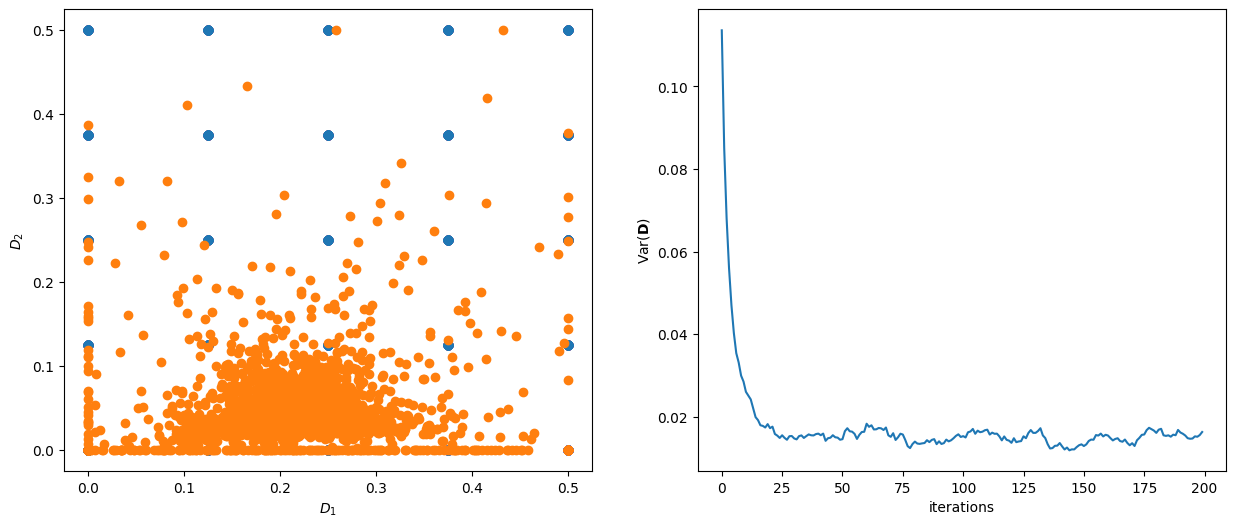

x_best =  [0.21417855 0.05087572 0.21072415 0.05149948 0.42375744]
f_max =  [1.64753534]


In [46]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].scatter(s_start[:,0], s_start[:,1], alpha=0.3)
ax[0].scatter(s0[:,0], s0[:,1])
ax[1].plot(disps)
ax[0].set_xlabel(r'$D_1$')
ax[0].set_ylabel(r'$D_2$')

ax[1].set_xlabel(r'iterations')
ax[1].set_ylabel(r'Var($\mathbf{D})$')
plt.show()
print('x_best = ', s0.mean(axis=0))
print('f_max = ', f(np.expand_dims(s0.mean(axis=0), axis=0)))

# Random-mean

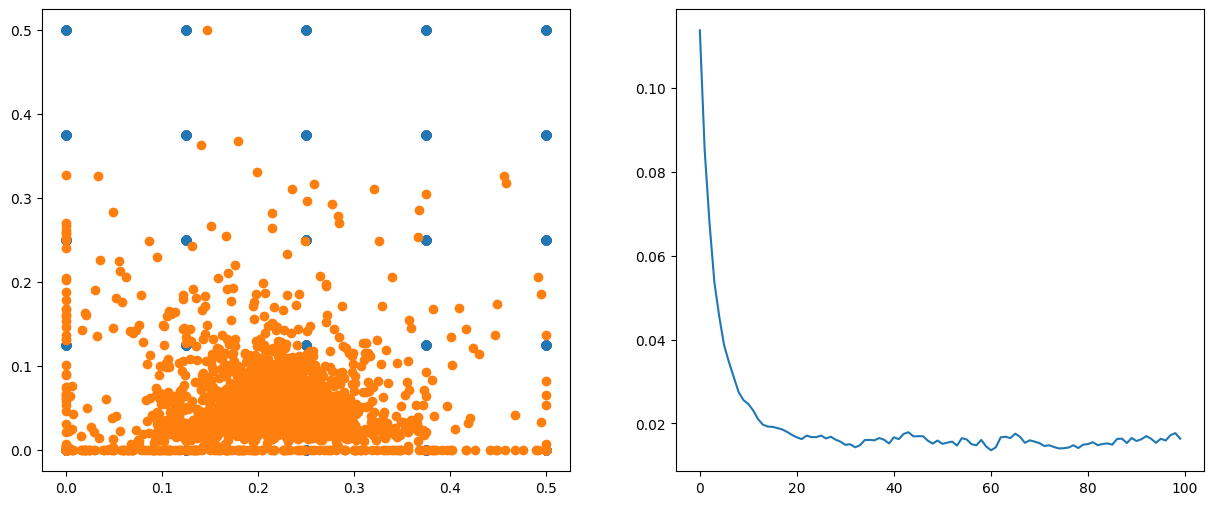

100%|██████████| 100/100 [20:58<00:00, 12.58s/it]

x_best =  [0.20831965 0.0543359  0.20618099 0.05260117 0.41668727]
f_max =  [1.50167011]


In [30]:
def f(x_vec):
    res = []
    for x in x_vec:
        prices = 1 - x
        for i in range(10):
            rew0 = 0
            rew_arr = []
            for c in env.c_list:
                rew, sold = c.substep(prices)
                rew0 += rew
            rew_arr.append(rew0)
        res.append(np.mean(rew_arr))
    return np.array(res)

np.random.seed(1234)

lower = np.full(K_GROUPS,0.)
upper = np.full(K_GROUPS,0.5)
x0 = np.linspace(lower[0],upper[0],5)
s_start = np.array(list(product(x0, repeat=K_GROUPS)))
s0 = s_start.copy()
disps = []
for i in tqdm(range(100)):
    f0 = f(s0)
    proba = np.exp(f0) / np.exp(f0).sum() #selection
    s1_idx = np.array([np.random.choice(len(s0), 2, p=proba, replace=False) for i in range(len(s0))])
    s1 = s0[s1_idx].mean(axis=1)
    mut_idx = np.array([random.random() for i in range(len(s0))])
    mask = mut_idx < 1/5
    s1[mask] += np.random.normal(scale=0.2, size=((mask).sum(),K_GROUPS)) #mutation
    s1 = np.clip(s1, lower, upper)
    s01 = np.append(s0,s1, axis=0)
    s0 = s01[np.argsort(f(s01))[len(s0):]]
    
    disps.append(s0.var(axis=0).sum())
    if (i+1) % 20 == 0:
        clear_output()
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        ax[0].scatter(s_start[:,0], s_start[:,1], alpha=0.3)
        ax[0].scatter(s0[:,0], s0[:,1])
        ax[1].plot(disps)
        plt.show()
        print('x_best = ', s0.mean(axis=0))
        print('f_max = ', f(np.expand_dims(s0.mean(axis=0), axis=0)))

# Random additional

<Axes: xlabel='Группа товаров', ylabel='Объём покупок'>

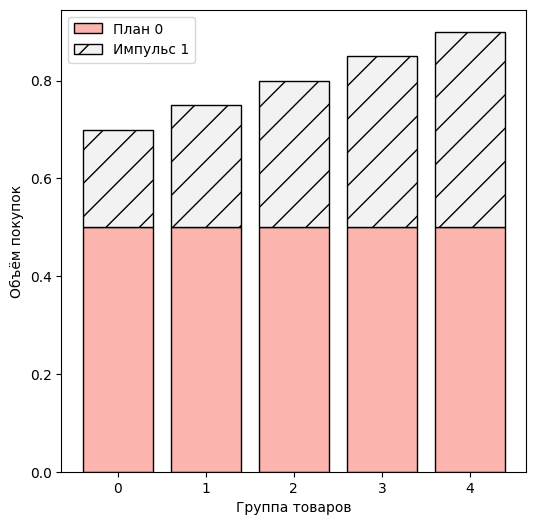

In [2]:
K_GROUPS = 5
K_CONS_GROUPS = 5
K_ADD_GROUPS = K_GROUPS
K_ACTIONS = 6

add_config = np.array([20,25,30,35,40]) / 100

func = ImpulseFunc(base=0., coef=1.7)
cons_list = [ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=2.5),
             ImpulseConsumer(K_GROUPS, K_ADD_GROUPS, func, add_budget=add_config.sum())]
cons_list[1].add_policy = add_config
env = MarketEnv(K_GROUPS, k_actions=3, fix_stock=100, consumer_list=cons_list, max_ep=50, action_type='step')
policy_plot(env)

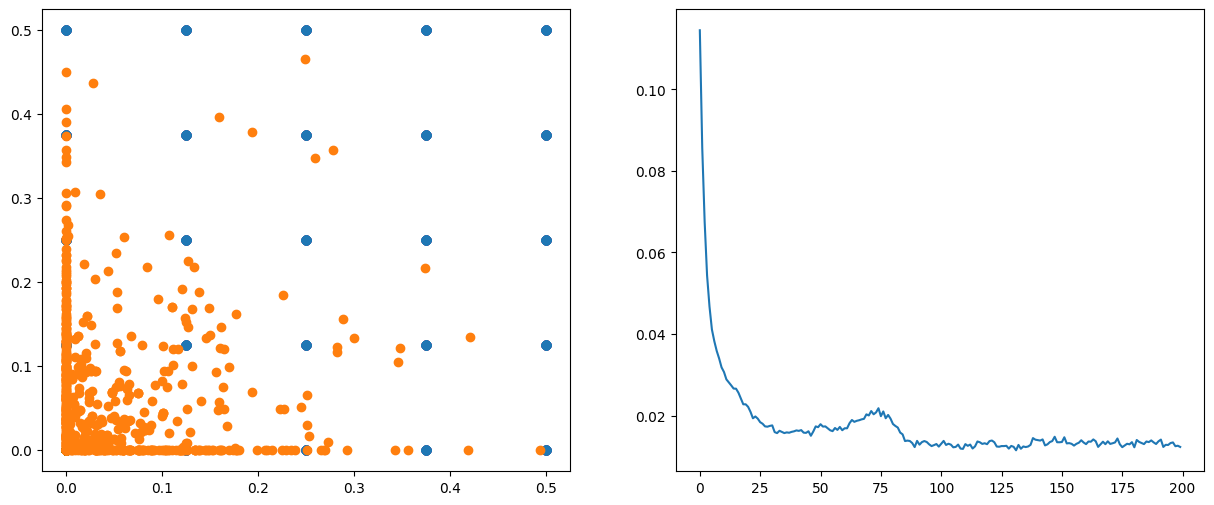

100%|██████████| 200/200 [03:34<00:00,  1.07s/it]

x_best =  [0.0103932  0.01387216 0.01590414 0.0167549  0.01793921]
f_max =  [2.46256819]


In [3]:
def f(x_vec):
    res = []
    for x in x_vec:
        prices = 1 - x
        rew0 = 0
        for c in env.c_list:
            rew, sold = c.substep(prices)
            rew0 += rew
        res.append(rew0)
    return np.array(res)

np.random.seed(1234)

lower = np.full(K_GROUPS,0.)
upper = np.full(K_GROUPS,0.5)
x0 = np.linspace(lower[0],upper[0],5)
s_start = np.array(list(product(x0, repeat=K_GROUPS)))
s0 = s_start.copy()
disps = []
for i in tqdm(range(200)):
    f0 = f(s0)
    proba = np.exp(f0) / np.exp(f0).sum() #selection
    s1_idx = np.array([np.random.choice(len(s0), 2, p=proba, replace=False) for i in range(len(s0))])
    s1 = s0[s1_idx].mean(axis=1)
    mut_idx = np.array([random.random() for i in range(len(s0))])
    mask = mut_idx < 1/5
    s1[mask] += np.random.normal(scale=0.2, size=((mask).sum(),K_GROUPS)) #mutation
    s1 = np.clip(s1, lower, upper)
    s01 = np.append(s0,s1, axis=0)
    s0 = s01[np.argsort(f(s01))[len(s0):]]
    
    disps.append(s0.var(axis=0).sum())
    if (i+1) % 20 == 0:
        clear_output()
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        ax[0].scatter(s_start[:,0], s_start[:,1], alpha=0.3)
        ax[0].scatter(s0[:,0], s0[:,1])
        ax[1].plot(disps)
        plt.show()
        print('x_best = ', s0.mean(axis=0))
        print('f_max = ', f(np.expand_dims(s0.mean(axis=0), axis=0)))